In [3]:
from sys import prefix

import SCOTCH
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import pooch
import matplotlib.pyplot as plt
import torch

### Loading single cell data 

SCOTCH allows loading through three interfaces, plain text files, anndata objects, or pytorch pt. files. For this example we will work with the exampledata scat is used for the scverse and scanpy tutorials. The data that are using is the 2021 NeurIPS benchmarking dataset. The samples used in this data were measured with the 10X multiome gene expression and chromatin accessibility kit. We will focus on the filtered expression matrices. That data contains ~16,000 from two different donors and span 36,601 genes. 

For this tutorial we utilize the beginning of the guide for scanpy which downloads the data into a standard adata object (adata). 

In [5]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [6]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
adata.var_names_make_unique()
print(adata.obs["sample"].value_counts())

/opt/anaconda3/envs/SCOTCH/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/SCOTCH/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/opt/anaconda3/envs/SCOTCH/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/SCOTCH/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/SCOTCH/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


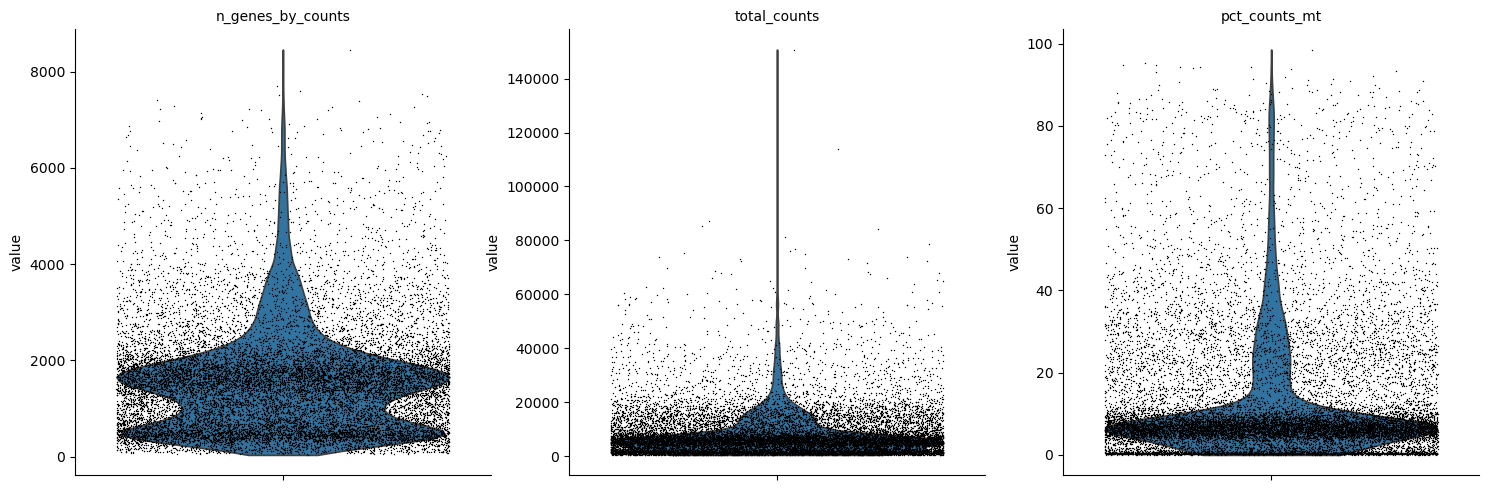

In [7]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

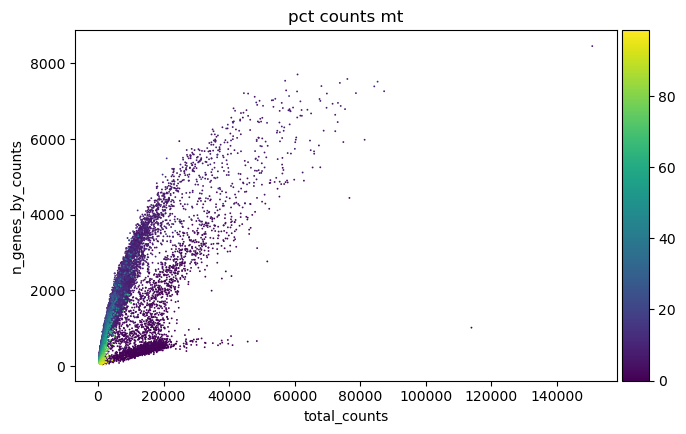

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
#sc.pp.scrublet(adata, batch_key="sample")

In [10]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
adata_high_var = adata[:, adata.var["highly_variable"]]

### Initializing a SCOTCH object

Now we can initialize SCOTCH. SCOTCH is a matrix tri factorization approach that estimates the data as multiplication of three matrices. 

$X \approx U S V^{T}$ where $U$ is a near orthogonal matrix which is used to cluster the cell space, $V$ is a near orthogonal matrix which is used to cluster the gene space, and $S$ is relationship matrix which relates gene and cell clusters. 

To start SCOTCH we need to initialize a SCOTCH object, and specify the number of cluster we want to use for the cell space (k1), and the number of cluster for the gene space (k2). We can also specify regularization parameters such as $\lambda_u$ or $\lambda_v$ which can be tuned to improve the orthogonality of the cell and gene clusters respectively. 


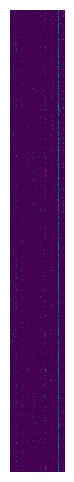

In [12]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
X_dense = adata_high_var.X.toarray() if hasattr(adata_high_var.X, 'toarray') else adata_high_var.X
ax.imshow(X_dense, interpolation="nearest", cmap='viridis')
ax.set_axis_off()

## Running SCOTCH with mutliple parameter settings 

In [14]:
l_values =  [0.15] #np.arange(0., 0.15, 0.15)

for l_u in l_values:
        l_v = l_u
        print(f"Running SCOTCH with max_l_u={l_u:.2f} and max_l_v={l_v:.2f}")
        scotch = SCOTCH.SCOTCH(k1=10, k2=15, max_l_u=l_u, max_l_v=l_v, term_tol=1e-5, var_lambda=False,
                               device="cpu", init_style="random", verbose=False)
        scotch.add_data_from_adata(adata_high_var)
        scotch.send_to_gpu()
        scotch.fit() 
        scotch.send_to_cpu()
        scotch.assign_cluster()
        adata_high_var = scotch.add_scotch_embeddings_to_adata(adata_high_var, f"lU_{l_u:.2f}_lV_{l_v:.2f}") ## adds the data to adata object, 

Running SCOTCH with max_l_u=0.15 and max_l_v=0.15


/Users/shalberg/Desktop/SCOTCH/SCOTCH/SCOTCH.py:184: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[prefix + 'cell_clusters'] = pd.Categorical(self.U_assign.detach().numpy())


In [15]:
adata_high_var

AnnData object with n_obs × n_vars = 17041 × 2000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'lU_0.15_lV_0.15_cell_clusters'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'lU_0.15_lV_0.15_gene_clusters'
    uns: 'log1p', 'hvg', 'lU_0.15_lV_0.15_S_matrix', 'lU_0.15_lV_0.15_reconstruction_error', 'lU_0.15_lV_0.15_error'
    obsm: 'lU_0.15_lV_0.15_cell_embedding', 'lU_0.15_lV_0.

## Comparing matrix reconstruction 

After running SCOTCH for multiple parameter setting we can quickly compare different models added to the same adata object. A useful metric for comparing the different regualrization methods is the reconstruction error, e.g. $$ || X - U S V^T ||_F^2 $$ There is amethod which will extract all such errors and plot for any adata object.   

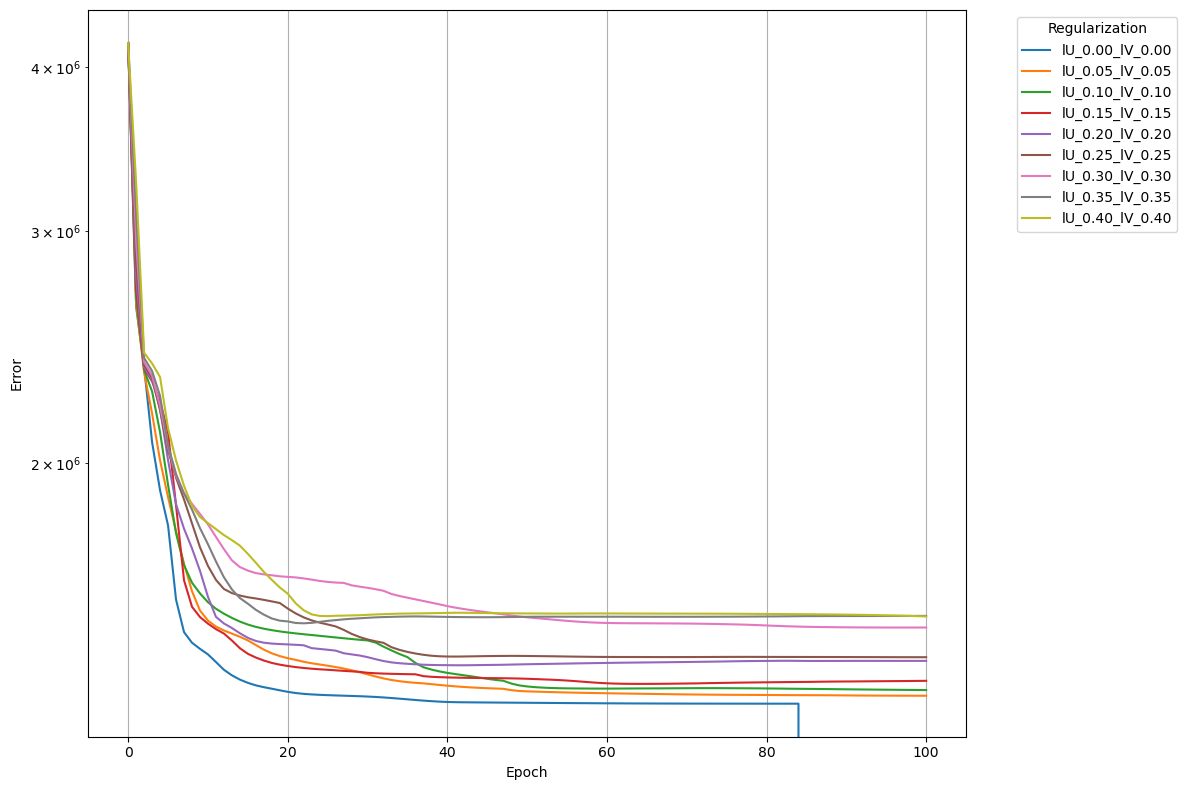

In [12]:
scotch.plot_reconstruction_error(adata_high_var)

as well as comparing the actual matrices. 

In [13]:
V = torch.tensor(adata_high_var.varm["lU_0.15_lV_0.15_gene_embedding"]).t()
V.shape
max_V, max_V_idx = V.max(dim=0)
sorting_criteria = torch.stack([max_V_idx, max_V], dim=1)
print(sorting_criteria)

tensor([[7.0000e+00, 3.8361e-02],
        [7.0000e+00, 5.2744e-03],
        [7.0000e+00, 8.5052e-03],
        ...,
        [7.0000e+00, 8.6122e-03],
        [1.2000e+01, 8.8145e-01],
        [3.0000e+00, 3.9926e-01]])


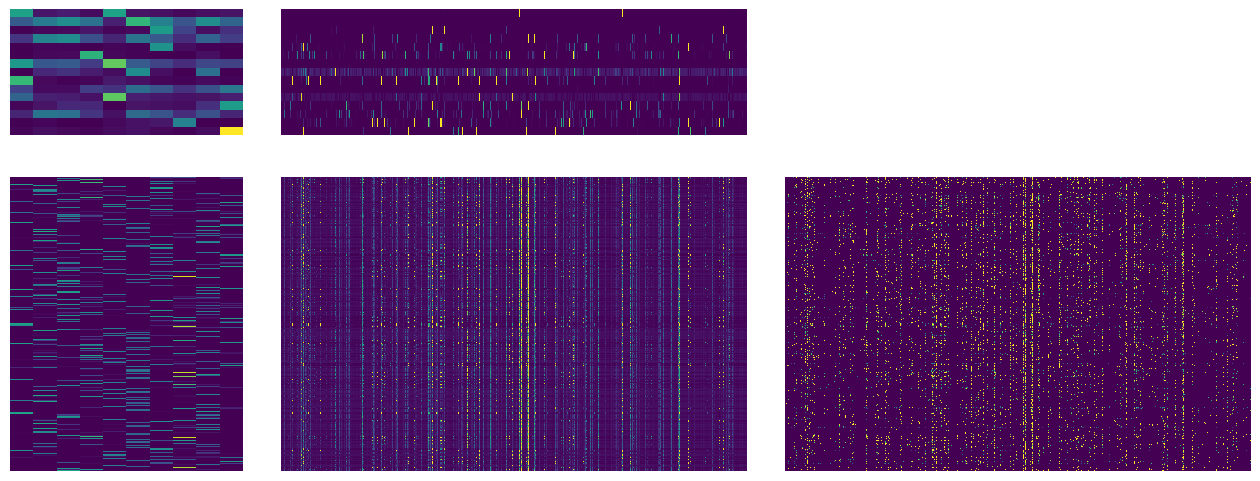

<Figure size 1600x600 with 0 Axes>

In [14]:
prefix = "lU_0.15_lV_0.15"
scotch.visualize_adata_factors(adata = adata_high_var, prefix = prefix, max_v = 0.1, max_x = 0.1)

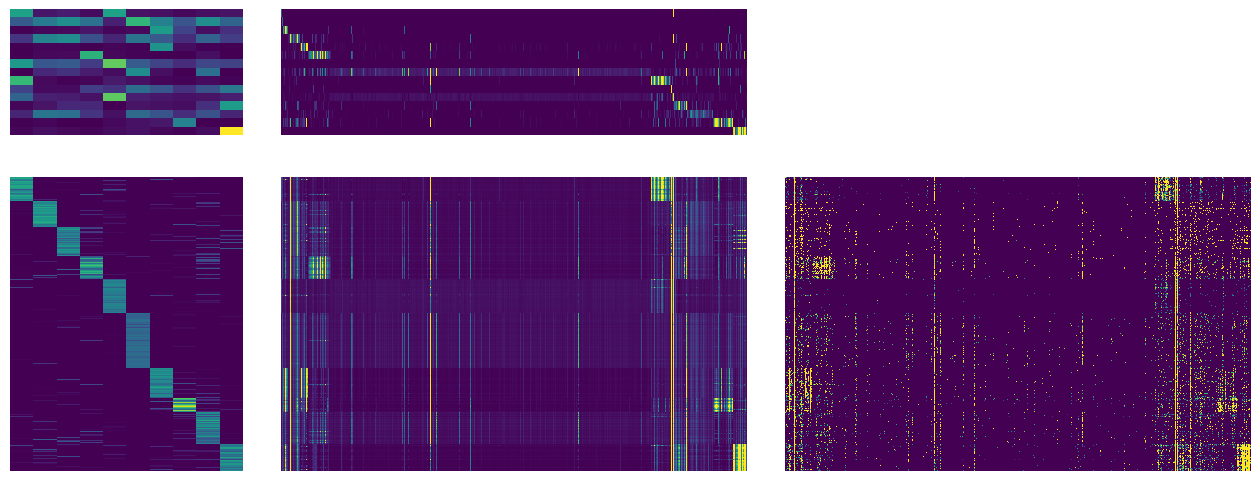

In [15]:
scotch.visualize_adata_factors_sorted(adata = adata_high_var, prefix = prefix, max_v = 0.1, max_x = 0.1)

In [16]:
sc.pp.pca(adata_high_var)
sc.pp.neighbors(adata_high_var, use_rep= "X_pca", metric = "cosine")
sc.tl.umap(adata_high_var)

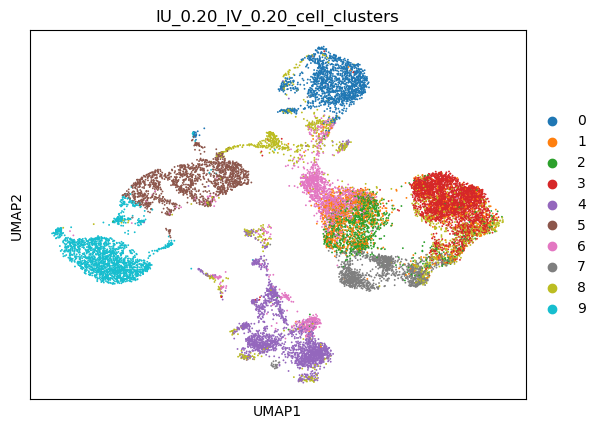

In [17]:
sc.pl.umap(adata_high_var, color = prefix + "_cell_clusters")

In [ ]:
#sc.pp.neighbors(adata_high_var, use_rep= "lU_0.20_lV_0.20_cell_embedding", metric = "cosine")
#sc.tl.umap(adata_high_var)
#sc.pl.umap(adata_high_var, color = "lU_0.20_lV_0.20_cell_clusters")

In [ ]:
#sc.pp.neighbors(adata_high_var, use_rep= "lU_0.40_lV_0.40_P_embedding", metric = "cosine")
#sc.tl.umap(adata_high_var)
#sc.pl.umap(adata_high_var, color = "lU_0.40_lV_0.40_cell_clusters")

In [19]:
top_k = 2
top_genes = scotch.make_top_regulators_list(adata_high_var, prefix=prefix, top_k=top_k)
top_genes

[(0, Index(['HBD', 'AHSP'], dtype='object')),
 (1, Index(['MALAT1', 'KIAA2026'], dtype='object')),
 (2, Index(['CD74', 'HLA-DRB1'], dtype='object')),
 (3, Index(['MTRNR2L12', 'MT-ND5'], dtype='object')),
 (4, Index(['IGHM', 'CD79A'], dtype='object')),
 (5, Index(['NKG7', 'CCL5'], dtype='object')),
 (6, Index(['HBB'], dtype='object')),
 (7, Index(['JUN', 'IL7R'], dtype='object')),
 (8, Index(['CA1', 'PRDX2'], dtype='object')),
 (9, Index(['FTL', 'FTH1'], dtype='object')),
 (10, Index(['HBA2', 'HBA1'], dtype='object')),
 (11, Index(['NEAT1', 'SAT1'], dtype='object')),
 (12, Index(['MT-ND2', 'MTRNR2L8'], dtype='object')),
 (13, Index(['CD79B', 'SOX4'], dtype='object')),
 (14, Index(['S100A9', 'S100A8'], dtype='object'))]

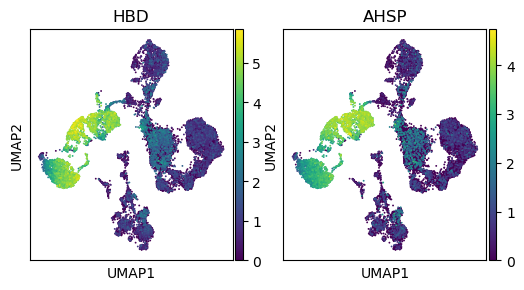

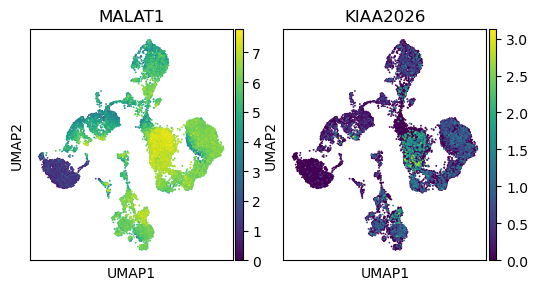

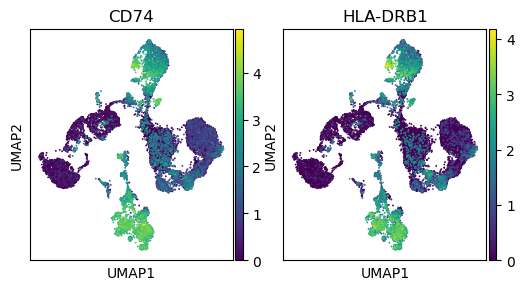

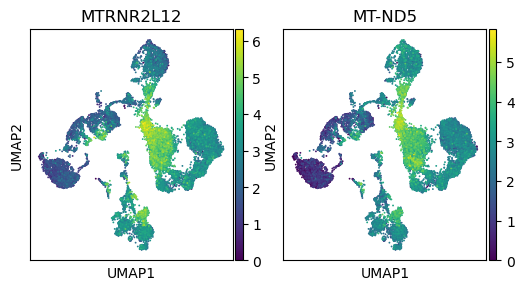

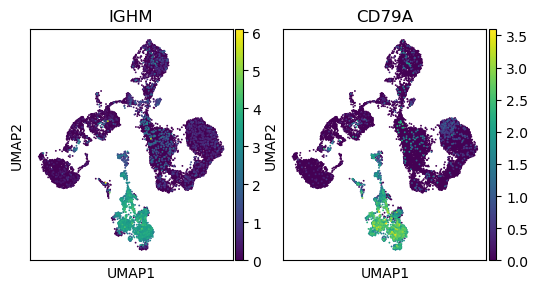

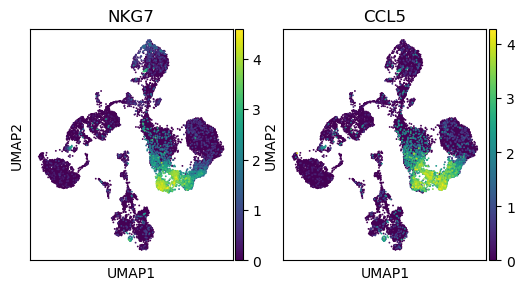

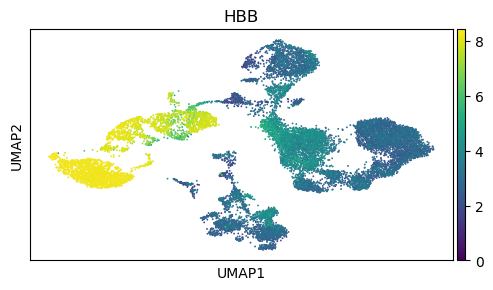

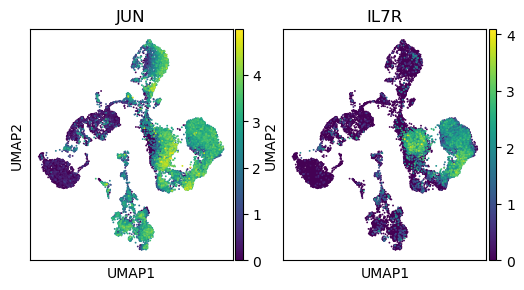

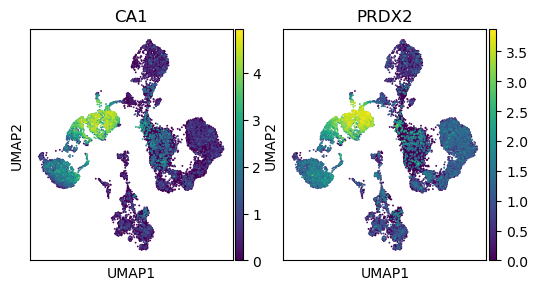

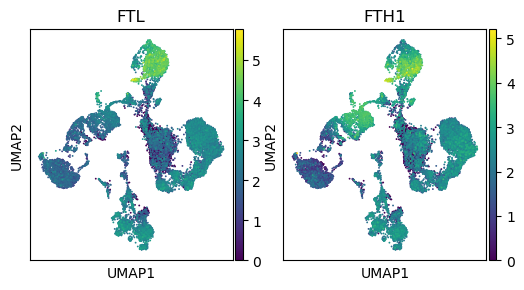

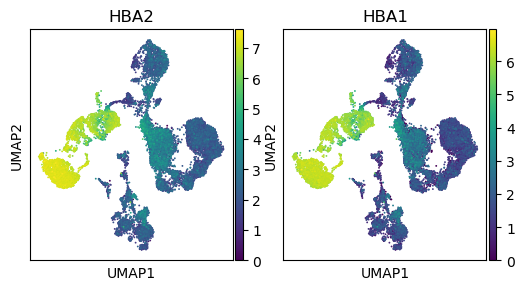

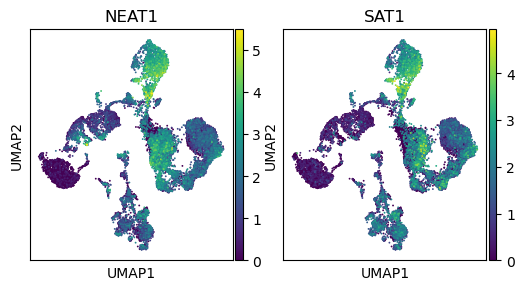

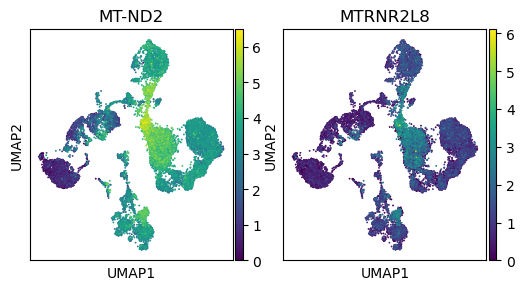

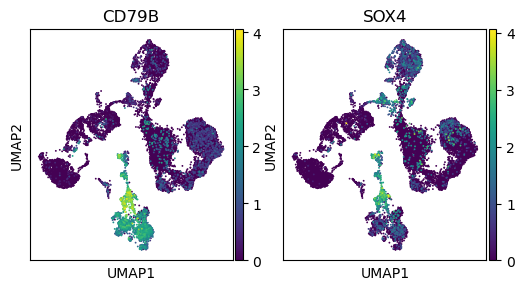

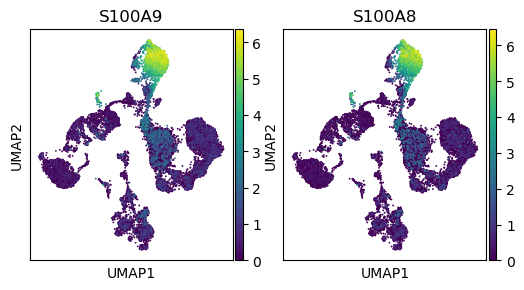

In [22]:
for k in range(15):
    genes = top_genes[k][1]     
    fig = sc.pl.umap(adata_high_var,
                     color=genes,
                     ncols=top_k,
                     return_fig=True
                     )
    fig.set_size_inches(6, 3)

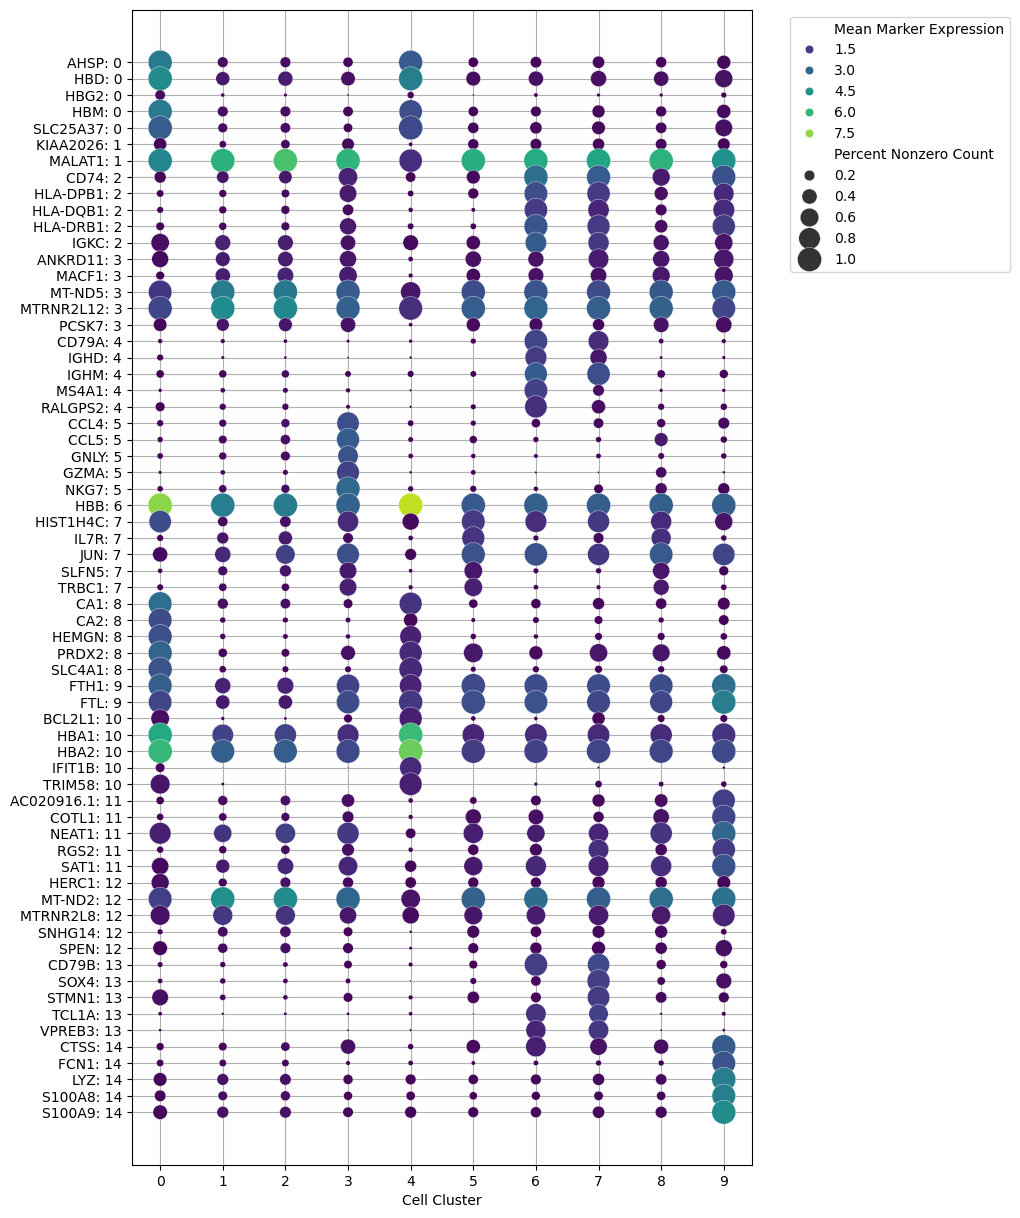

In [26]:
fig = scotch.visualize_marker_gene_bubbleplot_per_cell_cluster(adata_high_var,
                                                               prefix = prefix,
                                                               palette='viridis')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')



In [31]:
scotch.run_enrich_analyzer(adata_high_var, 'lU_0.10_lV_0.10_gene_clusters',
                           go_regnet_file='test/geneontology_cnames_lev_3_4_regnet.txt')

Read in 3080 terms for  14451 genes
Pval 0.0142616 Corr 0.114093
Pval 0.039627 Corr 0.158508
Pval 0.0788218 Corr 0.210191
Pval 0.17067 Corr 0.34134
Pval 0.196584 Corr 0.314534
Pval 0.260069 Corr 0.346759
Pval 0.27791 Corr 0.317611
Pval 0.334887 Corr 0.334887
Pval 2.89788e-05 Corr 0.0161122
Pval 5.07585e-05 Corr 0.0141109
Pval 0.000163453 Corr 0.0302933
Pval 0.000163453 Corr 0.02272
Pval 0.00428474 Corr 0.476463
Pval 0.0103184 Corr 0.956175
Pval 0.0116379 Corr 0.924384
Pval 0.0144873 Corr 1.00687
Pval 0.0157643 Corr 0.973882
Pval 0.0176326 Corr 0.980374
Pval 0.0196309 Corr 0.992254
Pval 0.0196309 Corr 0.909566
Pval 0.0247961 Corr 1.06051
Pval 0.0247961 Corr 0.984757
Pval 0.0255713 Corr 0.947843
Pval 0.0255713 Corr 0.888603
Pval 0.0262397 Corr 0.858191
Pval 0.0306992 Corr 0.948263
Pval 0.0306992 Corr 0.898355
Pval 0.0362877 Corr 1.0088
Pval 0.0378923 Corr 1.00324
Pval 0.0378923 Corr 0.957641
Pval 0.0378923 Corr 0.916004
Pval 0.0378923 Corr 0.877837
Pval 0.043103 Corr 0.958611
Pval 0.0431

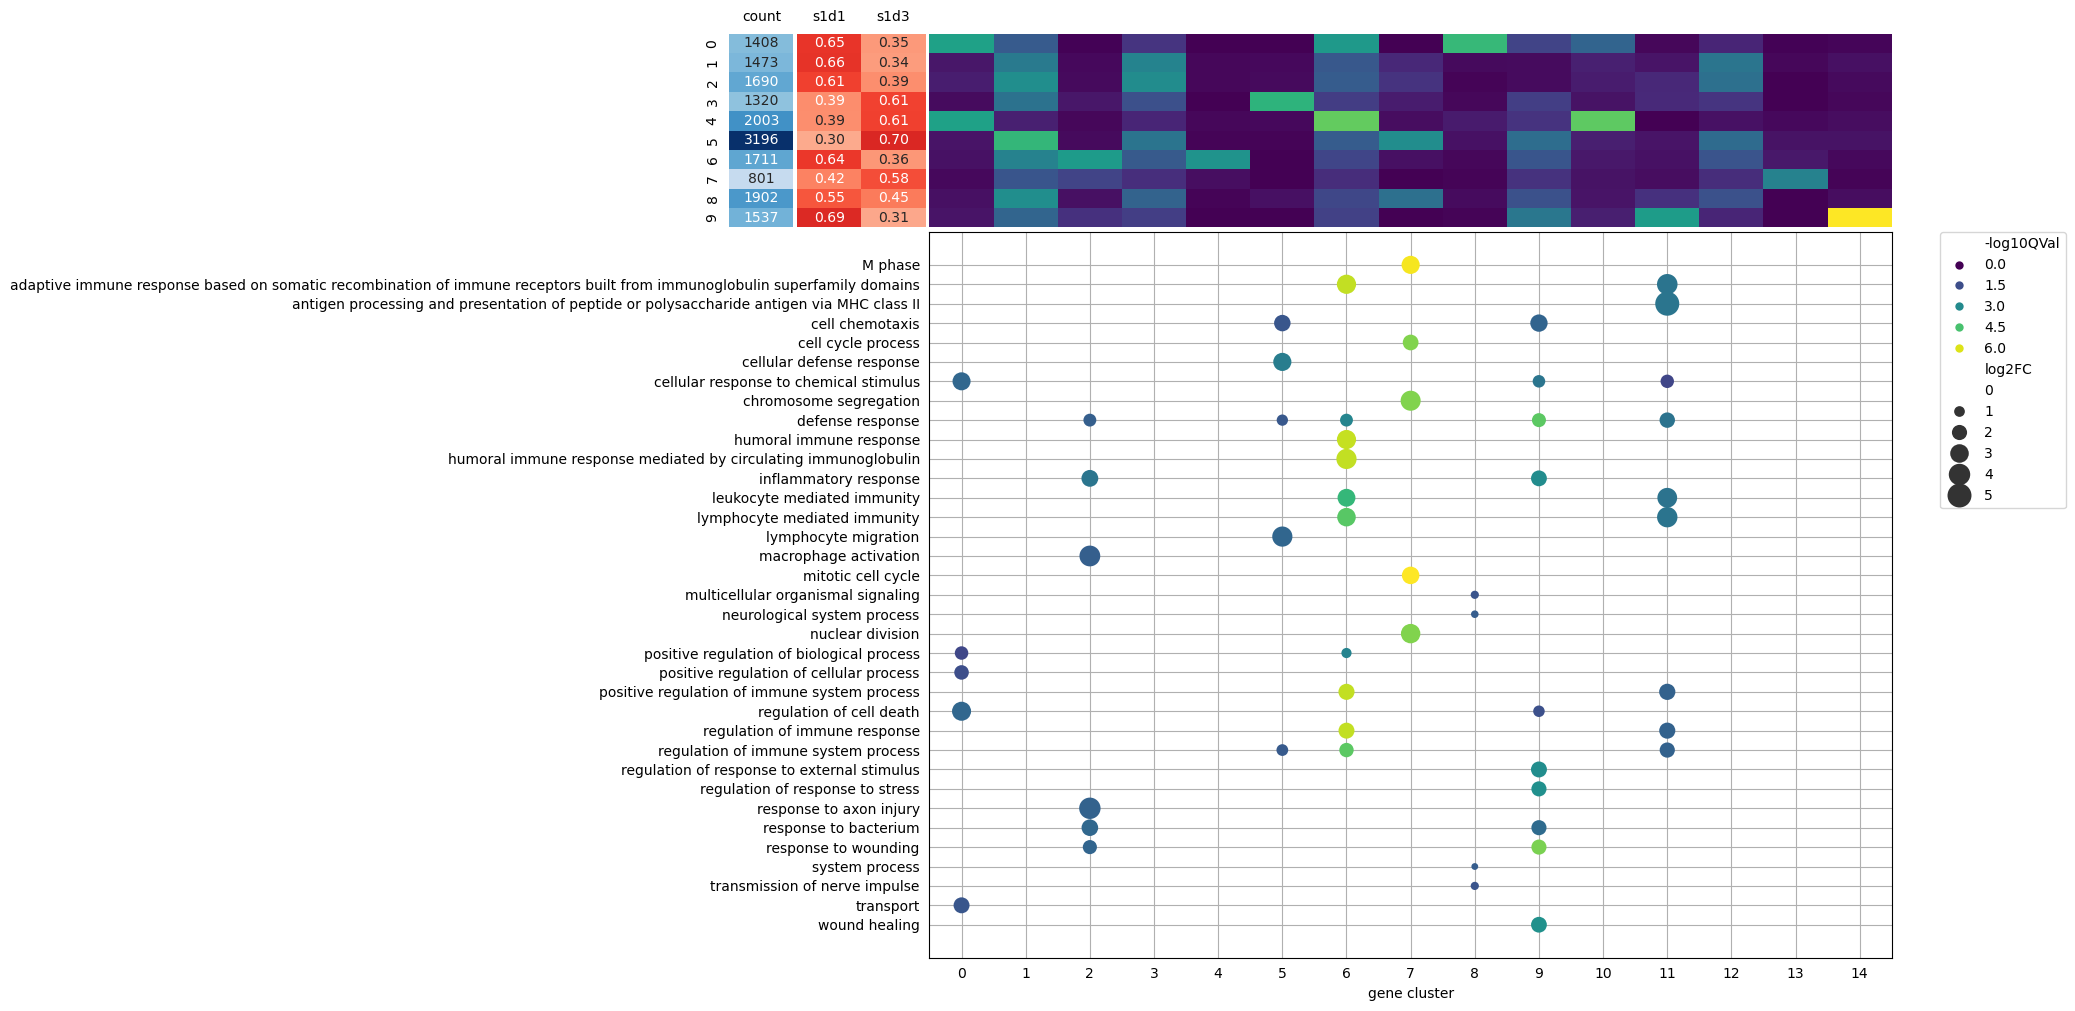

In [34]:
fig = scotch.combined_enrichment_visualization(adata_high_var, enrich_object_id='GO_enrichment',
                                               var1 = prefix + '_cell_clusters',
                                               var2='sample', 
                                               S_matrix_id = prefix + '_S_matrix')
fig.subplots_adjust(hspace=0.01, wspace=0.01)


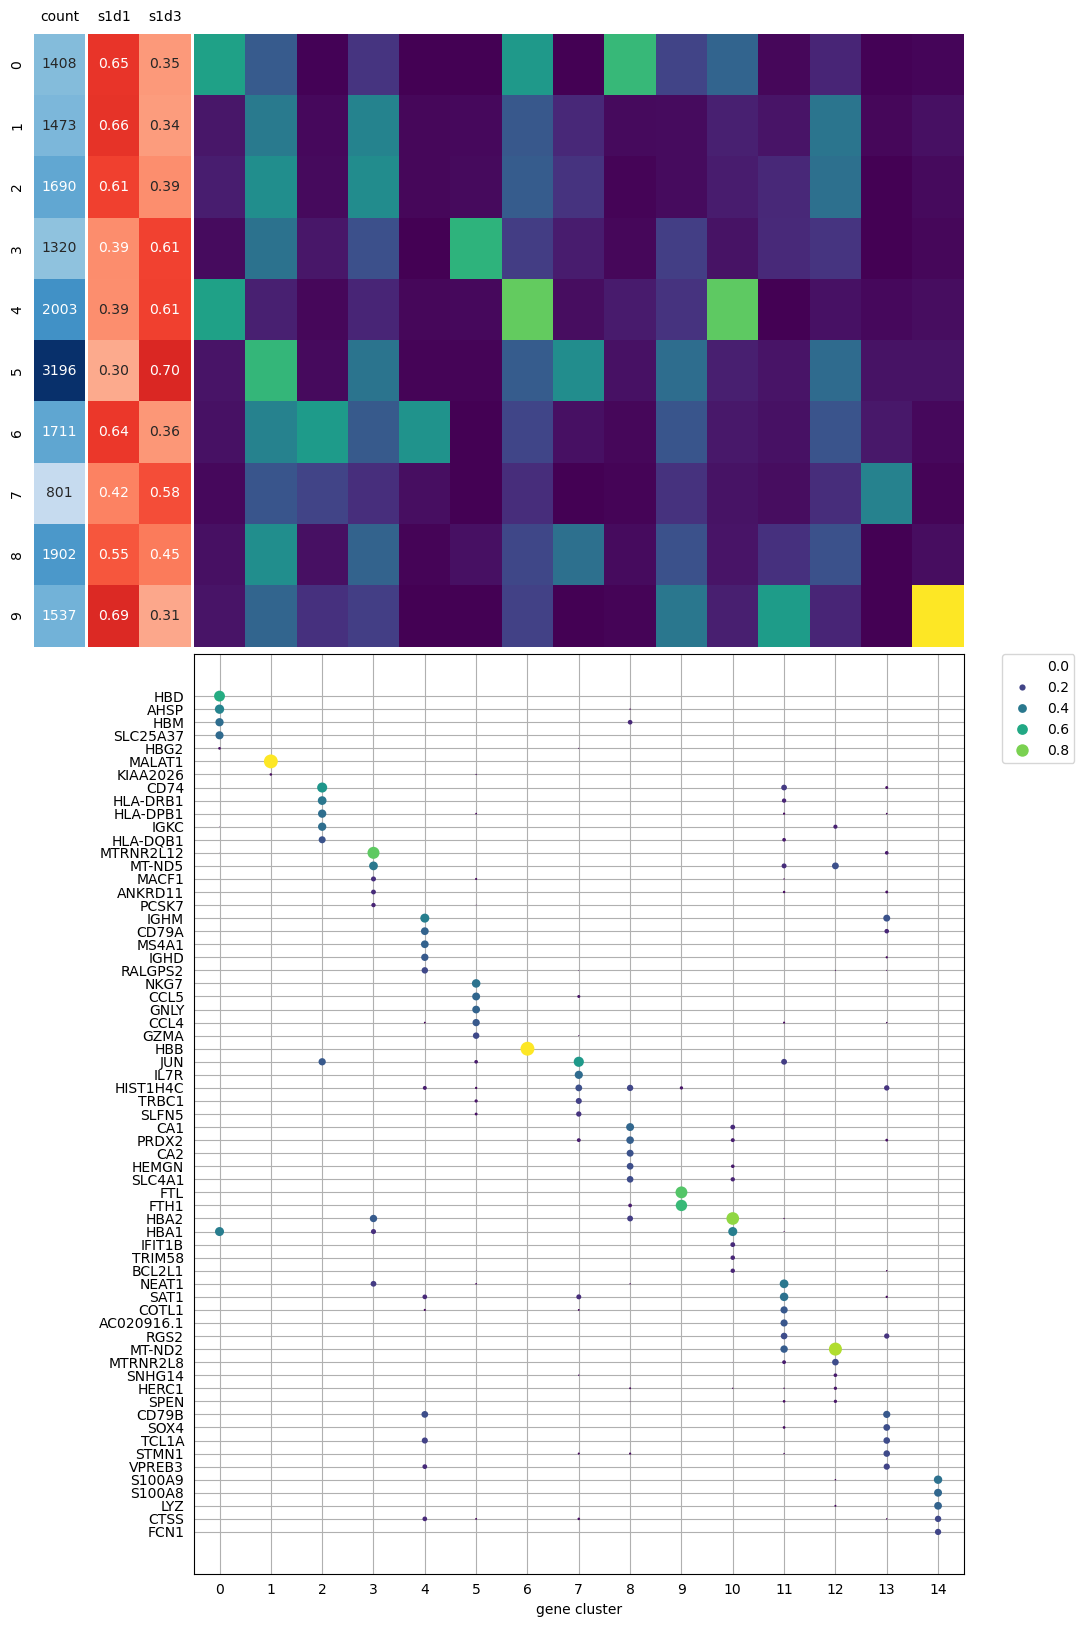

In [41]:
fig = scotch.combined_embedding_visualization(adata_high_var,
                                         gene_cluster_id = prefix + '_gene_clusters',
                                         gene_embedding_id=prefix + '_gene_embedding',
                                         top_k=2, max_point_size=100,
                                         palette='viridis',
                                         var1=prefix + '_cell_clusters', 
                                         var2='sample', 
                                         S_matrix_id= prefix + "_S_matrix")
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.set_size_inches(12, 20)